# K-means Clustering using DTW distance example

In [1]:
import numpy as np
import pickle
import random
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def EuclidDistance(s1,s2):
    Len1 = len(s1)
    Len2 = len(s2)
    if Len1 != Len2:
        print('Warring: Difference of Dimension!')
    return np.sqrt(sum(np.subtract(s1,s2)**2))


def DTWDistance(s1, s2,w):
    DTW={}

    w = max(w, abs(len(s1)-len(s2)))

    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

def LB_Keogh(s1,s2,r):
# The Dynamic Time Warping (DTW) is a popular similarity measure between time series. 
# The DTW fails to satisfy the triangle inequality and its computation requires quadratic  time.  
# Hence,  to  find  closest  neighbors  quickly,  we  use  bounding  tech-niques.
# We can avoid most DTW computations with an inexpensive lower bound (LB Keogh)
    LB_sum=0
    for ind,i in enumerate(s1):

        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])

        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2

    return np.sqrt(LB_sum)


def k_means_clust(data,num_clust, w=5, min_Cent=3):
    centroids = random.sample(data,num_clust)
    #old_centroids = np.add(new_centroids,10)
    counter=0
    assignments={}
    while True:
        counter+=1
        #print('iter: {it}'.format(it=counter))
        assignments={}
        #assign data points to clusters
        for ind,i in enumerate(data):
            min_dist=float('inf')
            closest_clust=None
            for c_ind,j in enumerate(centroids):
                if LB_Keogh(i,j,w) < min_dist:
                    cur_dist=DTWDistance(i,j,w)
                    if cur_dist < min_dist:
                        min_dist=cur_dist
                        closest_clust=c_ind
            if closest_clust in assignments:
                assignments[closest_clust].append(ind)
            else:
                assignments[closest_clust]=[ind]
        #print('Round-{r} Centroids : {cents}'.format(r=counter, cents=str(centroids)))
        print('Round-{r}'.format(r=counter))
        old_centroids = centroids
        #recalculate centroids of clusters
        for key in assignments:
            clust_sum=np.zeros(len(data[0]))
            for k in assignments[key]:
                clust_sum=clust_sum+data[k]
            centroids[key]=[m/len(assignments[key]) for m in clust_sum]
        isConvergence = True
        for i in range(num_clust):
            if EuclidDistance(old_centroids[i], centroids[i]) != 0:
                isConvergence = False
                break
        if isConvergence:
            break
        #ss = 0
        #for key in groups:    
        #    for each in clus[key]:
        #        ss = ss + EuclidDistance(each,center[key])
    print('\n======== Fianl Assignments ================================')
    print('{result}'.format(result=str(assignments)))
    return assignments


def k_means_clust_v2(data,num_clust, w=5, min_CentNum=3, min_CentRate=0.1,
                     showAssignments=False, show_excTime=True):
    if show_excTime:
        start_time = time.time()
    centroids = random.sample(list(range(len(data))), num_clust)
    counter = 0
    assignments = {}
    while True:
        counter+=1
        assignments = {}
        for idx in centroids:
            assignments[idx] = [idx]
        #assign data points to clusters
        for idx, ts in enumerate(data):
            if idx in centroids:
                continue
            min_dist = float('inf')
            closest_clust = None
            for c_idx in centroids:
                if LB_Keogh(ts, data[c_idx], w) < min_dist:
                    cur_dist = DTWDistance(ts, data[c_idx], w)
                    if cur_dist < min_dist:
                        min_dist = cur_dist
                        closest_clust = c_idx
            assignments[closest_clust].append(idx)
        print('Round-{r} Centroids Index : {cents}'.format(r=counter, cents=str(centroids)))
        old_centroids = centroids
        centroids = []
        #print(assignments)
        #recalculate centroids of clusters
        for c_idx in assignments:
            group_members = assignments[c_idx]
            sample_CentNum = max(min_CentNum, int(len(assignments[c_idx])*min_CentRate))
            sample_CentNum = min(sample_CentNum, len(assignments[c_idx]))
            #print('{gid} sample_cen = {sc}'.format(gid=key, sc=sample_cen))
            cent_candidate = random.sample(group_members[1:], sample_CentNum-1)
            
            new_cent = group_members[0]
            err=  0
            for idx in group_members:
                err += DTWDistance(data[new_cent], data[idx], w)
            min_dist = err / len(group_members)
            for i in range(sample_CentNum-1):
                cand_cent = cent_candidate[i]
                err = 0
                for idx in group_members:
                    err += DTWDistance(data[cand_cent], data[idx], w)
                avg_err = err / len(group_members)
                if avg_err < min_dist:
                    new_cent = cent_candidate[i]
                    min_dist = avg_err
            centroids.append(new_cent)
            
        isConvergence = True
        for i in range(num_clust):
            if centroids[i] != old_centroids[i]:
                isConvergence = False
                break
        if isConvergence:
            break
    
    if showAssignments:
        print('\n======== Fianl Assignments ================================')
        for cent_idx in assignments:
            print('{c} : {g}'.format(c=cent_idx, g=str(assignments[cent_idx])))
    else:
        print('\n======== Fianl Centroids ================================')
        print('Centroids Index : {cents}'.format(cents=str(list(assignments.keys()))))

    if show_excTime:
        print('\n======== Execution Time =================================')
        print("{t} seconds ".format(t=(time.time()-start_time)))
    
    return assignments


def plt_TimeSeries(time_series_list):
    xx = range(len(time_series_list[0]))
    for ts in time_series_list:
        plt.plot(xx, ts)
    plt.show()

def plt_ClusterTimeSeries(time_series_list, assignments):
    xx = range(len(time_series_list[0]))
    num_plt = len(assignments.keys())
    plt_count = 0
    plt.figure(figsize=(15,4*num_plt))
    for cent in assignments:
        plt.subplot(num_plt,1,plt_count+1)
        cmap = plt.get_cmap('Blues')
        number = len(assignments[cent])
        colors = [cmap(i) for i in np.linspace(0.4, 0.6, number)]
        for i, idx in enumerate(assignments[cent]):
            yy = time_series_list[idx]
            plt.plot(xx, yy, color=colors[i])
        yy = time_series_list[cent]
        plt.plot(xx, yy, color='r')
        plt_count += 1
    plt.show()


In [3]:
pkl_file = open('matrix_data.pkl','rb')
data = pickle.load(pkl_file)
pkl_file.close()

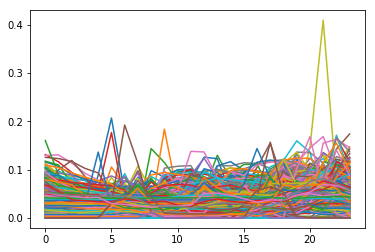

In [4]:
plt_TimeSeries(data[::10])

In [5]:
groups =  k_means_clust_v2(data[::10],num_clust=3,w=3)

Round-1 Centroids Index : [516, 200, 311]
Round-2 Centroids Index : [372, 837, 68]
Round-3 Centroids Index : [68, 401, 837]
Round-4 Centroids Index : [401, 237, 837]

======== Fianl Centroids ================================
Centroids Index : [401, 237, 837]

======== Execution Time =================================
80.04234004020691 seconds 


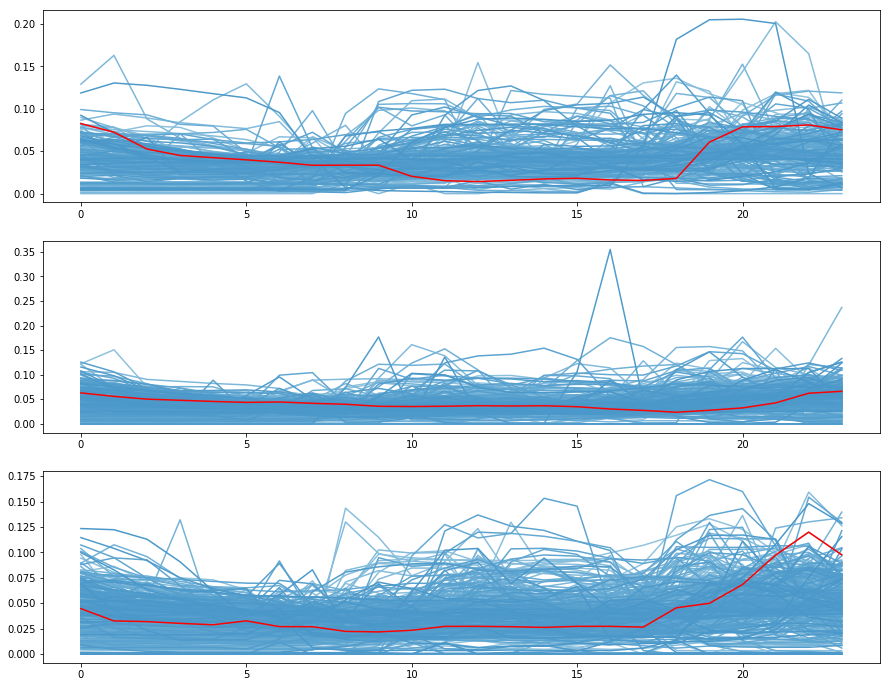

In [14]:
plt_ClusterTimeSeries(data, groups)

In [48]:
groups =  k_means_clust_v2(data,num_clust=5,w=2)

Round-1 Centroids Index : [6272, 8457, 7528, 7748, 2506]
Round-2 Centroids Index : [4865, 6203, 4656, 2764, 3081]
Round-3 Centroids Index : [4865, 6750, 3791, 7130, 7938]
Round-4 Centroids Index : [5664, 8387, 3791, 7130, 2369]
Round-5 Centroids Index : [5664, 8387, 4340, 7130, 2369]

======== Fianl Centroids ================================
Centroids Index : [5664, 8387, 4340, 7130, 2369]

======== Execution Time =================================
2189.761065006256 seconds 


In [33]:
def plt_ClusterSeries(time_series_list, assignments):
    xx = range(len(time_series_list[0]))
    num_plt = len(assignments.keys())
    plt_count = 0
    plt.figure(figsize=(15,10))
    ppyy=[]
    for cent in assignments:
        plt.subplot(np.ceil(num_plt/2),2,plt_count+1)
        plt.title("Group"+str(plt_count+1))
        pyy=[]
        for i, idx in enumerate(assignments[cent]):
            yy = time_series_list[idx]
            pyy.append(yy)
            plt.plot(xx, yy, color='b')
        yy = np.mean(pyy,axis=0)
        ppyy.append(yy)
        plt.plot(xx, yy, color='r',linewidth=5.0)
        plt_count += 1
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(15,10))
    for gp in ppyy:
        plt.plot(xx,gp)
    plt.show()

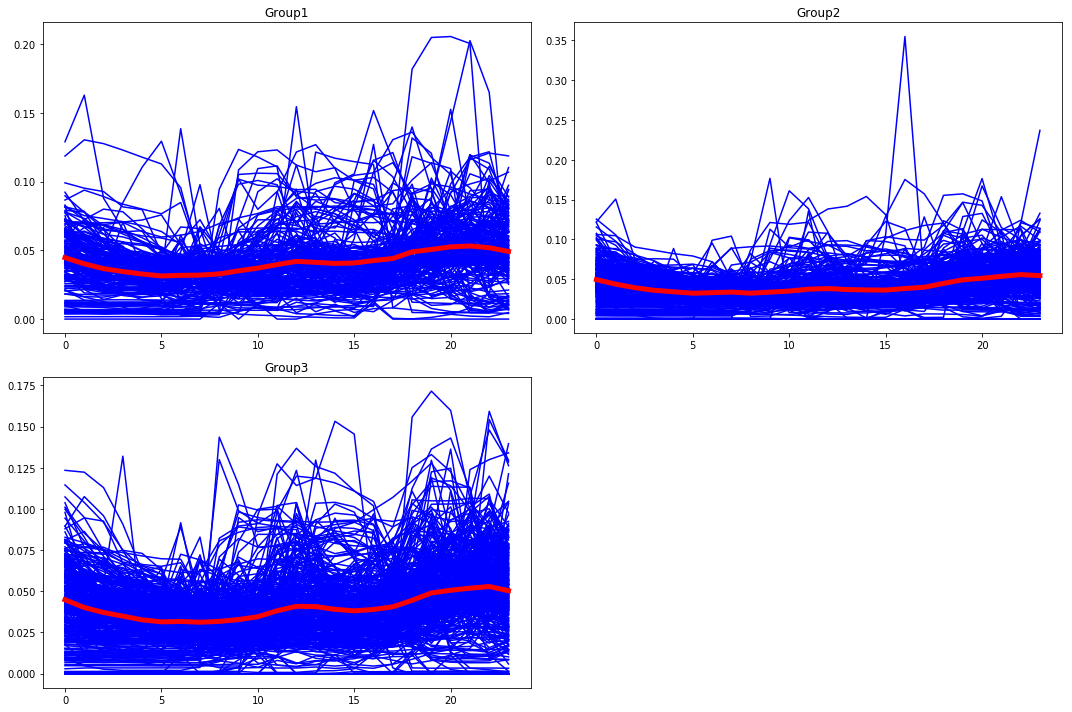

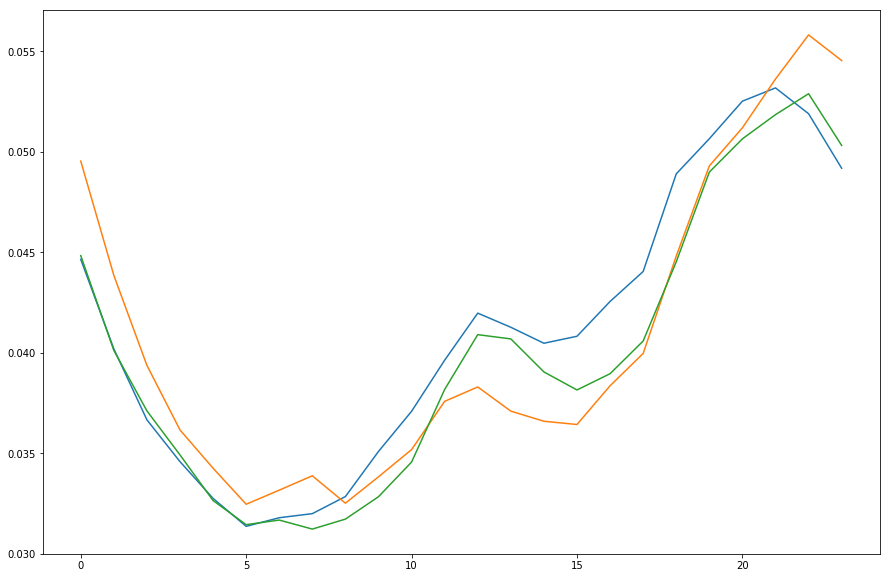

In [34]:
plt_ClusterSeries(data, groups)